# Medical Images Registeration

In this part, we will explore MR and CT Images Registeration


**Registeration method summary:**

Creating an instance of the registration framework requires selection of the following components:
   * Optimizer.
   * Similarity metric.
   * Interpolator.


## Registration Components 

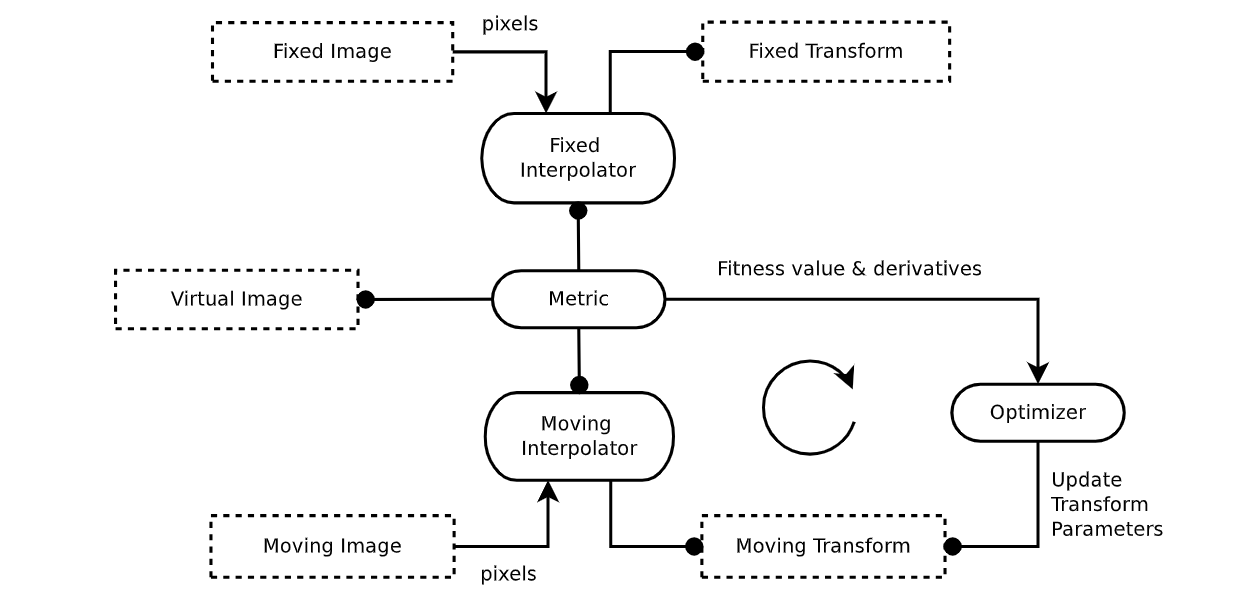

There are many options for creating an instance of the registration framework, all of which are configured in SimpleITK via methods of the <a href="https://simpleitk.org/doxygen/latest/html/classitk_1_1simple_1_1ImageRegistrationMethod.html">ImageRegistrationMethod</a> class. This class encapsulates many of the components available in ITK for constructing a registration instance.

Currently, the available choices from the following groups of ITK components are:

### Optimizers

The SimpleITK registration framework supports several optimizer types via the SetOptimizerAsX() methods, these include:

<ul>
  <li>
  <a href="http://www.itk.org/Doxygen/html/classitk_1_1ExhaustiveOptimizerv4.html">Exhaustive</a>
  </li>
  <li>
  <a href="http://www.itk.org/Doxygen/html/classitk_1_1AmoebaOptimizerv4.html">Nelder-Mead downhill simplex</a>, a.k.a. Amoeba.
  </li>
  <li>
   <a href="https://itk.org/Doxygen/html/classitk_1_1PowellOptimizerv4.html">Powell optimizer</a>.
  </li>
  <li>
   <a href="https://itk.org/Doxygen/html/classitk_1_1OnePlusOneEvolutionaryOptimizerv4.html">1+1 evolutionary optimizer</a>.
  </li>
  <li>
  Variations on gradient descent:
  <ul>
    <li>
    <a href="http://www.itk.org/Doxygen/html/classitk_1_1GradientDescentOptimizerv4Template.html">GradientDescent</a>
    </li>
    <li>
    <a href="http://www.itk.org/Doxygen/html/classitk_1_1GradientDescentLineSearchOptimizerv4Template.html">GradientDescentLineSearch</a>
    </li>
    <li>
    <a href="http://www.itk.org/Doxygen/html/classitk_1_1RegularStepGradientDescentOptimizerv4.html">RegularStepGradientDescent</a>
    </li>
  </ul>
  </li>
  <li>
    <a href="http://www.itk.org/Doxygen/html/classitk_1_1ConjugateGradientLineSearchOptimizerv4Template.html">ConjugateGradientLineSearch</a> 
  </li>
  <li>
  <a href="https://itk.org/Doxygen/html/classitk_1_1LBFGS2Optimizerv4.html">L-BFGS2</a> (Limited memory Broyden,  Fletcher,Goldfarb,Shannon)
  </li>
  <li>
  <a href="http://www.itk.org/Doxygen/html/classitk_1_1LBFGSBOptimizerv4.html">L-BFGS-B</a> (Limited memory Broyden,  Fletcher,Goldfarb,Shannon-Bound Constrained) - supports the use of simple constraints ($l\leq x \leq u$)  
  </li>
    
</ul>

 
### Similarity metrics

The SimpleITK registration framework supports several metric types via the SetMetricAsX() methods, these include:

<ul>
  <li>
  <a href="http://www.itk.org/Doxygen/html/classitk_1_1MeanSquaresImageToImageMetricv4.html">MeanSquares</a>
  </li>
  <li>
  <a href="http://www.itk.org/Doxygen/html/classitk_1_1DemonsImageToImageMetricv4.html">Demons</a>
  </li>
  <li>
  <a href="http://www.itk.org/Doxygen/html/classitk_1_1CorrelationImageToImageMetricv4.html">Correlation</a>
  </li>
  <li>
  <a href="http://www.itk.org/Doxygen/html/classitk_1_1ANTSNeighborhoodCorrelationImageToImageMetricv4.html">ANTSNeighborhoodCorrelation</a>
  </li>
  <li>
  <a href="http://www.itk.org/Doxygen/html/classitk_1_1JointHistogramMutualInformationImageToImageMetricv4.html">JointHistogramMutualInformation</a>
  </li>
  <li>
  <a href="http://www.itk.org/Doxygen/html/classitk_1_1MattesMutualInformationImageToImageMetricv4.html">MattesMutualInformation</a>
  </li>
</ul>


### Interpolators

The SimpleITK registration framework supports several interpolators via the SetInterpolator() method, which receives one of
the <a href="https://simpleitk.org/doxygen/latest/html/namespaceitk_1_1simple.html#a7cb1ef8bd02c669c02ea2f9f5aa374e5">following enumerations</a>:
<ul>
<li> sitkNearestNeighbor </li>
<li> sitkLinear </li>
<li> sitkBSpline </li>
<li> sitkGaussian </li>
<li> sitkHammingWindowedSinc </li>
<li> sitkCosineWindowedSinc </li>
<li> sitkWelchWindowedSinc </li>
<li> sitkLanczosWindowedSinc </li>
<li> sitkBlackmanWindowedSinc </li>
</ul>

Installing Libraries

In [ ]:
!pip install SimpleITK matplotlib numpy ipympl 

In [ ]:
import SimpleITK as sitk
from downloaddata import fetch_data as fdata

%matplotlib ipympl
import gui
import registration_gui as rgui
import matplotlib.pyplot as plt
import numpy as np
import os

OUTPUT_DIR = "output"

## Read images

We first read the images, specifying the pixel type that is required for registration (Float32 or Float64) and look at them. In this notebook we use a CT and MR image from the same patient. These are part of the training data from the Retrospective Image Registration Evaluation (<a href="https://rire.insight-journal.org/">RIRE</a>) project.

In [ ]:
fixed_image = sitk.ReadImage(fdata("training_001_ct.mha"), sitk.sitkFloat32)
moving_image = sitk.ReadImage(fdata("training_001_mr_T1.mha"), sitk.sitkFloat32)

ct_window_level = [835, 162]
mr_window_level = [1036, 520]

gui.MultiImageDisplay(
    image_list=[fixed_image, moving_image],
    title_list=["fixed", "moving"],
    figure_size=(8, 4),
    window_level_list=[ct_window_level, mr_window_level],
);


SimpleITK provides a function called  [CenteredTransformInitializer](https://itk.org/Doxygen/html/classitk_1_1CenteredTransformInitializer.html) to help you set up the initial alignment.

#### Key Concepts:
1. **Fixed Image vs. Moving Image**:
   - The **fixed image** is the reference image that remains static.
   - The **moving image** is the one you align to the fixed image.

2. **Transformations**:
   - A [transformations](https://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/22_Transforms.html) defines how the moving image is adjusted. This includes translation (shifting), rotation, scaling, and more.
   - Common transformations:
     - **Rigid Transform (Euler3D)**: Allows rotation and translation.
     - **Affine Transform**: Adds scaling and shearing to rigid transformations.
     - **Translation Transform**: Only allows shifting.

3. **Initialization Methods**:
   - **Geometry-Based (GEOMETRY)**:
     - Aligns the geometric centers of the two images.
     - Useful when the intensity distributions of the images are noisy or unreliable.
   - **Moments-Based (MOMENTS)**:
     - Aligns the centers of mass of the intensity distributions of the images.
     - Works well when the images have similar intensity patterns.

#### What You Need to Do:
1. **Define a Transformation**:

2. **Choose an Initialization Method**:

3. **Apply the Initial Transformation**:




We initialize registration by [aligning the centers](https://itk.org/Doxygen/html/classitk_1_1CenteredTransformInitializer.html) of the two volumes. To qualitatively evaluate the result we use a linked cursor approach, click on one image and the corresponding point is added to the other image.



In [ ]:
initial_transform = #TODO

gui.RegistrationPointDataAquisition(
    fixed_image,
    moving_image,
    figure_size=(8, 4),
    known_transformation=initial_transform,
    fixed_window_level=ct_window_level,
    moving_window_level=mr_window_level,
);

Resampling is the process of transforming an image from one space to another based on a transformation while ensuring the pixel values are interpolated appropriately.

In [ ]:
registered_image = sitk.Resample(
    moving_image,             # The image to transform
    fixed_image,              # The reference image for alignment
    initial_transform,       # The composite transform
    sitk.sitkLinear,          # Interpolation method
    0.0,                      # Default pixel value for regions outside the image
    moving_image.GetPixelID() # Pixel type remains the same as the moving image
)


Visualize the results of image registration by overlaying the fixed image and the registered image. This visualization will help you assess the alignment quality.

hint: - Use `sitk.GetArrayViewFromImage()` to extract the image data from SimpleITK images

In [ ]:
#TO DO

## ITKv4 Coordinate Systems

Unlike the classical registration approach where the fixed and moving images are treated differently, the ITKv4 registration framework allows you to treat both images in the same manner. This is achieved by introducing a third coordinate system, the virtual image domain.

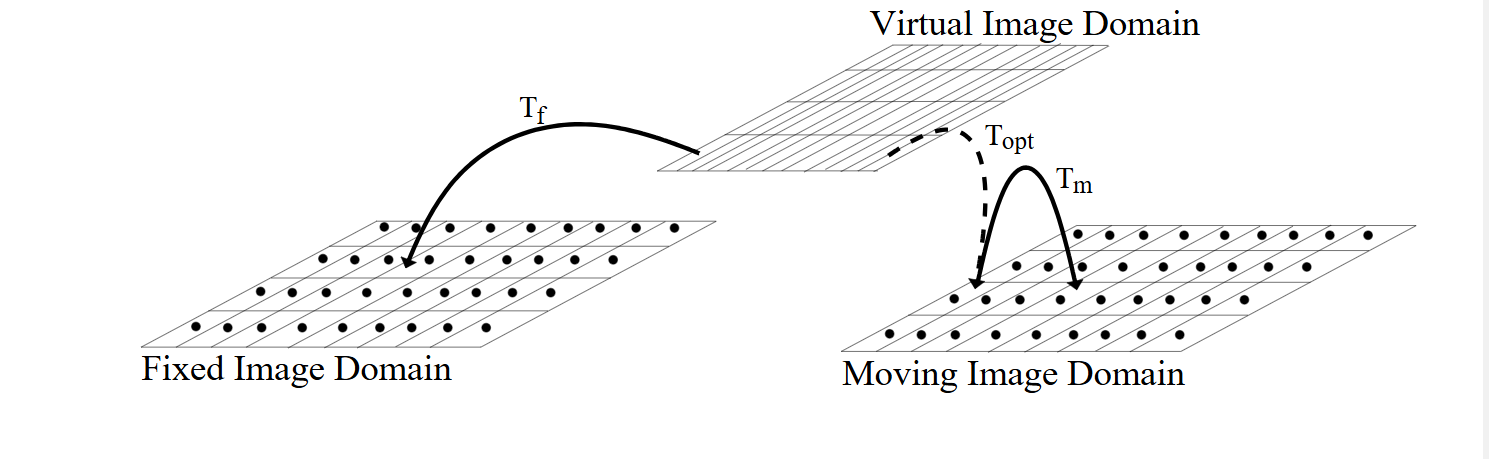

Thus, the ITK v4 registration framework deals with three transformations:
<ul>
<li>
SetInitialTransform, $T_{opt}$ - composed with the moving initial transform, maps points from the virtual image domain to the moving image domain, modified during optimization. 
</li>
<li>
SetFixedInitialTransform $T_f$- maps points from the virtual image domain to the fixed image domain, never modified.
</li>
<li>
SetMovingInitialTransform $T_m$- maps points from the virtual image domain to the moving image domain, never modified.
</li>
</ul>

The transformation that maps points from the fixed to moving image domains is thus: $^M\mathbf{p}  = T_m(T_{opt}(T_f^{-1}(^F\mathbf{p})))$

We now modify the previous example to use $T_{opt}$ and $T_m$.
---


---

Set up and execute a 3D image registration process using the [sitk.ImageRegistrationMethod](https://simpleitk.org/doxygen/v2_3/html/classitk_1_1simple_1_1ImageRegistrationMethod.html) class. This process optimizes the alignment between a fixed image and a moving image by iteratively refining a transformation.

#### Steps to Implement:

1. **Set Up the Registration Method**:
   - Create an instance of `sitk.ImageRegistrationMethod`.

2. **Configure the Similarity Metric**:
   - Use Mattes Mutual Information (`SetMetricAsMattesMutualInformation`) to measure the similarity between the fixed and moving images.
   - Specify the number of histogram bins and the sampling strategy:
     - **Sampling Strategy**: Randomly samples points from the images for faster computation.
     - **Sampling Percentage**: Determines the fraction of points to sample (e.g., 1%).

3. **Set the Interpolator**:
   - Define how pixel values are interpolated during registration. Linear interpolation (`sitk.sitkLinear`) is commonly used for smooth transitions.

4. **Configure the Optimizer**:
   - Use a gradient descent optimizer with:
     - **Learning Rate**: Controls the step size during optimization.
     - **Number of Iterations**: Maximum iterations for convergence.
     - **Convergence Criteria**: Stops optimization when changes in the metric are below a threshold for a specified window of iterations.

5. **Enable Multi-Resolution Framework**:
   - Perform registration at multiple scales to improve robustness:
     - **Shrink Factors**: Downsample the images for coarse-to-fine alignment.
     - **Smoothing Sigmas**: Apply Gaussian smoothing at each resolution level.

6. **Set the Initial Transform**:
   - Use the initial transform (e.g., `initial_transform`) computed earlier to provide a starting point.
   - Define an optimized transform (e.g., `Euler3DTransform`) that will be refined during registration.

7. **Add Observers for Real-Time Feedback**:
   - Add commands to monitor and visualize the registration process in real time (optional but helpful for debugging and understanding).

8. **Execute the Registration**:
   - Run the registration method with the fixed and moving images.
   - Compose the resulting transformation with the initial transform to get the final composite transform.

9. **Inspect the Results**:
   - Print the final similarity metric value and the optimizer’s stopping condition to evaluate the registration process.
.



By completing this exercise, you will gain a deeper understanding of how image registration is performed in practice and the significance of each step in the process.


---
Initial values to try with 

Estimate a 3D rigid transformation between images of different modalities. 

We have made the following choices with respect to initialization and registration component settings:

<ul>

<li>Similarity metric, mutual information (Mattes MI):
<ul>
  <li>Number of histogram bins, 50.</li>
  <li>Sampling strategy, random.</li>
  <li>Sampling percentage, 1%.</li>
</ul>
</li>
<li>Interpolator, sitkLinear.</li>
<li>Optimizer, gradient descent: 
<ul>
  <li>Learning rate, step size along traversal direction in parameter space, 1.0 .</li>
  <li>Number of iterations, maximal number of iterations, 100.</li>
  <li>Convergence minimum value, value used for convergence checking in conjunction with the energy profile of the similarity metric that is estimated in the given window size, 1e-6.</li>
  <li>Convergence window size, number of values of the similarity metric which are used to estimate the energy profile of the similarity metric, 10.</li>
</ul>
</li>
</ul>

---


In [ ]:
registration_method = #TODO

# Similarity metric settings. 
#TODO


#set the interpolator
#TODO

# Optimizer settings.
#TODO

# Setup for the multi-resolution framework.
registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Set the initial moving and optimized transforms.
#TODO

# Connect all of the observers so that we can perform plotting during registration.
registration_method.AddCommand(sitk.sitkStartEvent, rgui.start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, rgui.end_plot)
registration_method.AddCommand(
    sitk.sitkMultiResolutionIterationEvent, rgui.update_multires_iterations
)
registration_method.AddCommand(
    sitk.sitkIterationEvent, lambda: rgui.plot_values(registration_method)
)

# Need to compose the transformations after registration.
final_transform_v4 = sitk.CompositeTransform(
    [] #TODO    #execute the registeration_method
)

# Print the final metric value and optimizer stopping condition
#TODO

Qualitatively evaluate the result using a linked cursor approach (visual evaluation):



In [ ]:
gui.RegistrationPointDataAquisition(
    fixed_image,
    moving_image,
    figure_size=(8, 4),
    known_transformation=final_transform_v4,
    fixed_window_level=ct_window_level,
    moving_window_level=mr_window_level,
);

Resampling is the process of transforming an image from one space to another based on a transformation while ensuring the pixel values are interpolated appropriately.

In [ ]:
#TODO 


Visualize the results of image registration by overlaying the fixed image and the registered image. This visualization will help you assess the alignment quality.

hint: - Use `sitk.GetArrayViewFromImage()` to extract the image data from SimpleITK images

In [ ]:
#TODO

In [ ]:
def display_images_middle_slice(images, titles, cmap="gray"):
    fig, axes = plt.subplots(1, len(images), figsize=(10, 10))
    for i, (image, title) in enumerate(zip(images, titles)):
        # Calculate the middle slice along the z-axis
        middle_slice_index = image.GetSize()[2] // 2
        axes[i].imshow(sitk.GetArrayViewFromImage(image)[middle_slice_index, :, :], cmap=cmap)
        axes[i].set_title(title)
        axes[i].axis("off")
    plt.show()

display_images_middle_slice(
    [fixed_image, moving_image, registered_image],
    ["Fixed Image", "Moving Image", "Registered Image"]
)



Visualize the difference between the fixed image with the moving image before and after registration to evaluate the quality of alignment. By visualizing the difference images, you can easily identify areas that improved or remain misaligned after registration.

Hint: you can use `sitk.Abs` to calculate the difference between two sitk images



In [ ]:
#TODO

In [ ]:
display_images_middle_slice(
    [difference_before, difference_after],
    ["Difference Before Registration", "Difference After Registration"]
)

---
### Discussion

<br><br>1. What is the purpose of resampling in the context of image registration? <br>
<font color="#008000">Answer :</font>


<br><br> 2. Why is linear interpolation (sitk.sitkLinear) commonly used during resampling?
<br> <font color="#008000">Answer :</font>


<br><br> 3. What does the difference_after image indicate?
<br> <font color="#008000">Answer :</font>

<br><br> 4. How would changing the interpolation method (e.g., to nearest neighbor) affect the resampled image?
<br> <font color="#008000">Answer :</font>

<br><br>5. Why is it important to select an appropriate optimizer for image registration? <br>
<font color="#008000">Answer :</font>

<br><br> 6. How does the choice of similarity metric influence the registration outcome?
<br> <font color="#008000">Answer :</font>

<br><br> 7. How does gradient descent optimize the transformation parameters in registration?
<br> <font color="#008000">Answer :</font>

<br><br> 8. What is the role of learning rate in gradient descent optimization?
<br> <font color="#008000">Answer :</font>


<br><br> 9. What is the significance of using the Euler3DTransform for registration?
<br> <font color="#008000">Answer :</font>

<br><br> 10. How does the optimizer's stopping condition affect the registration process?
<br> <font color="#008000">Answer :</font>

<br><br> 11. What might happen if an inappropriate transformation model is chosen for a registration task?
<br> <font color="#008000">Answer :</font>







